In [3]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from config_file import data_path

            count
year_week        
2019-07-21      1
2019-07-28      1
2019-08-04      1
2019-08-11      1
2019-08-18      3


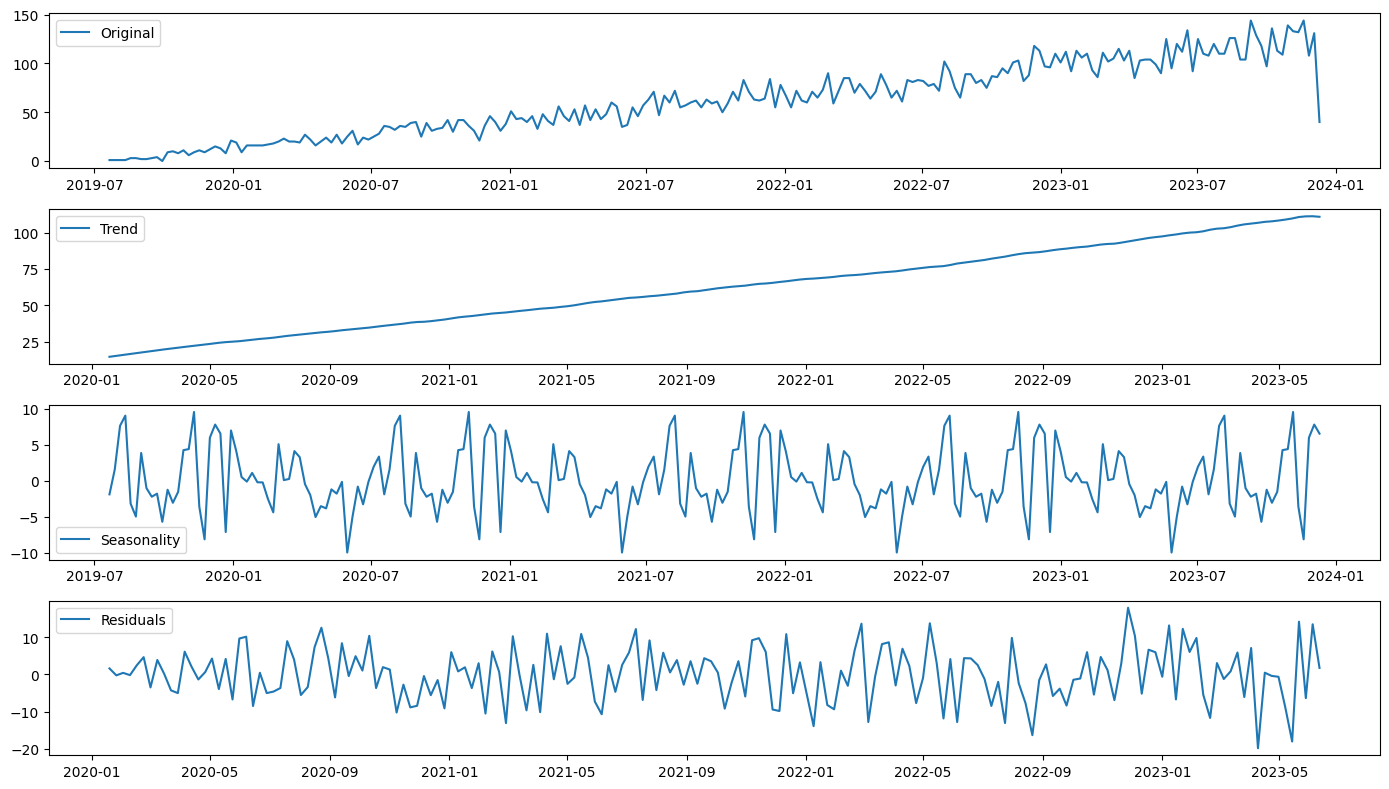

In [4]:
dir_with_plays = "plays_per_week"
artist_id = "0a1gHP0HAqALbEyxaD5Ngn"
data = pd.read_csv(os.path.join(data_path, dir_with_plays, f"{artist_id}.csv"), parse_dates=True)


# Convert 'year_week' to datetime
data['year_week'] = pd.to_datetime(data['year_week'] + '0', format='%Y_%W%w')

# Setting 'year_week' as the index
data.set_index('year_week', inplace=True)

# Resample the data weekly to ensure consistency
data = data.resample('W').sum()
print(data.head())
# Perform a seasonal decomposition to analyze trend, seasonality, and residuals
decomposition = seasonal_decompose(data['count'], model='additive')

# Plotting the decomposed components of the time series
plt.figure(figsize=(14, 8))
plt.subplot(411)
plt.plot(data['count'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [ ]:
import time
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings

# Setting the range of parameters to test
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in pdq]

warnings.filterwarnings("ignore")  # Ignoring warning messages for simplicity

best_aic = float('inf')
best_pdq = None
best_seasonal_pdq = None
best_model = None

# Grid search to find the best SARIMA model
inner_loop = 0
outer_loop = 0
for param in pdq:
    outer_timer = time.time()
    for param_seasonal in seasonal_pdq:
        inner_timer = time.time()
        try:
            model = SARIMAX(data['count'],
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results
                print(f"SARIMA{param}x{param_seasonal} - AIC: {results.aic}")
        except:
            continue
        print(f"Inner loop: {inner_loop}/{len(seasonal_pdq)} - Time: {time.time() - inner_timer}")
        
        inner_loop += 1
    print(f"Outer loop: {outer_loop}/{len(pdq)} - Time: {time.time() - outer_timer}")
    
    outer_loop += 1

(best_pdq, best_seasonal_pdq, best_aic)

SARIMA(0, 0, 0)x(0, 0, 0, 52) - AIC: 2611.2868630508387
Inner loop: 0/27 - Time: 0.04052543640136719
SARIMA(0, 0, 0)x(0, 0, 1, 52) - AIC: 2065.737589948981
Inner loop: 1/27 - Time: 2.3393568992614746
SARIMA(0, 0, 0)x(0, 0, 2, 52) - AIC: 1389.3765664401126
Inner loop: 2/27 - Time: 5.6611363887786865
Inner loop: 3/27 - Time: 0.16264748573303223
Inner loop: 4/27 - Time: 9.870566368103027
SARIMA(0, 0, 0)x(0, 1, 2, 52) - AIC: 698.7161050201038
Inner loop: 5/27 - Time: 18.092453241348267
Inner loop: 6/27 - Time: 1.2499480247497559
SARIMA(0, 0, 0)x(0, 2, 1, 52) - AIC: 663.7759017855201
Inner loop: 7/27 - Time: 8.008054733276367
Inner loop: 8/27 - Time: 0.2692220211029053


In [4]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(data['count'],
                order=(0, 0, 0),
                seasonal_order=(0, 2, 2, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary().tables[1])


/media/data/coding/ium/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L52      -1.7699   9319.362     -0.000      1.000   -1.83e+04    1.83e+04
ma.S.L104      0.9995   1.05e+04    9.5e-05      1.000   -2.06e+04    2.06e+04
sigma2       436.0477   4.59e+06    9.5e-05      1.000   -8.99e+06       9e+06


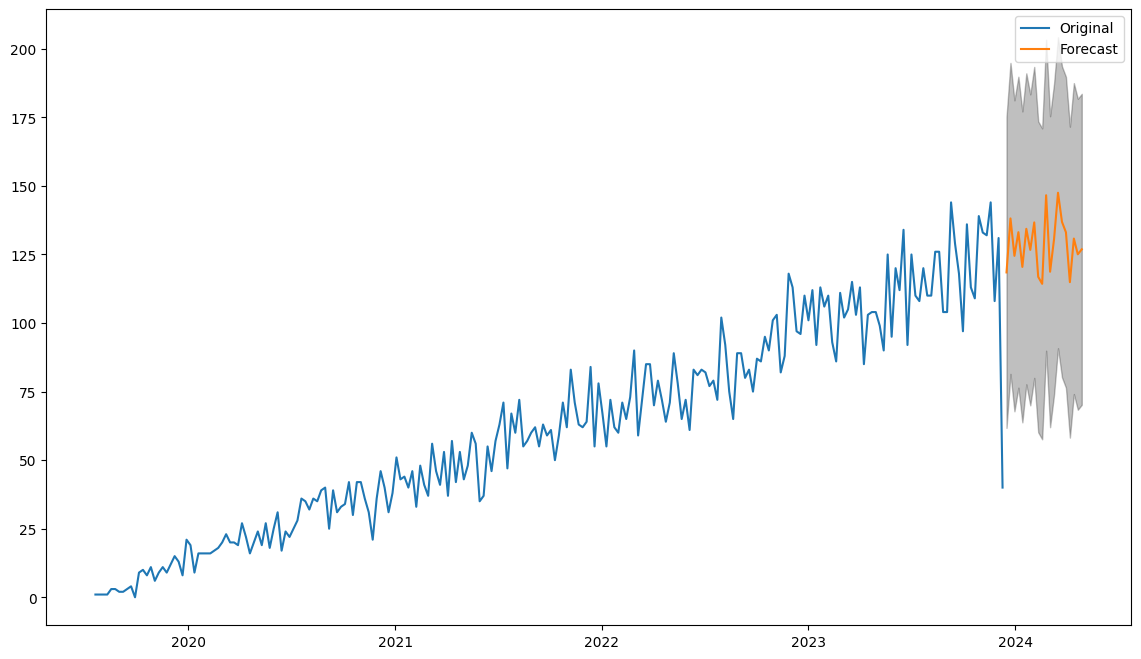

In [5]:
forecast = results.get_forecast(steps=20)
plt.figure(figsize=(14, 8))
plt.plot(data['count'], label='Original')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast.conf_int().index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='k', alpha=.25)
plt.legend(loc='best')
plt.show()

In [10]:
# split into train and test sets
X = data['count'].values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]

model = SARIMAX(train,
                order=(0, 0, 0),
                seasonal_order=(0, 2, 2, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
forecast = results.get_forecast(steps=len(test))



/media/data/coding/ium/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


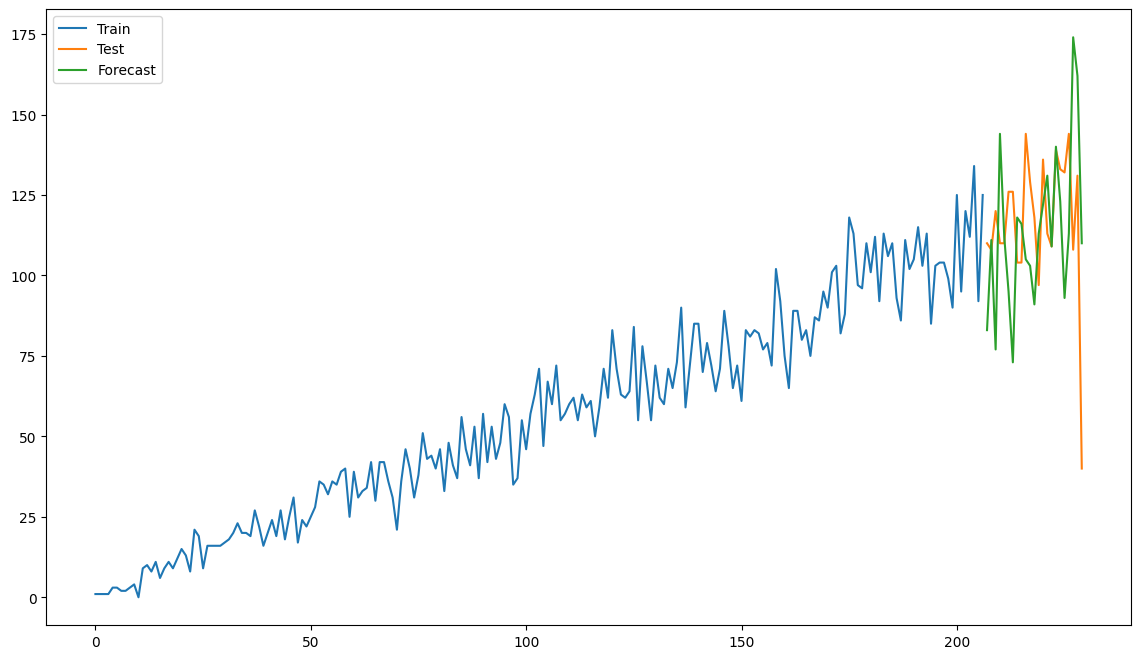

In [16]:
plt.figure(figsize=(14, 8))
plt.plot(train, label='Train')
plt.plot([None for i in train] + [x for x in test], label='Test')
plt.plot([None for i in train] + [x for x in forecast.predicted_mean], label='Forecast')
plt.legend(loc='best')
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, forecast.predicted_mean))
print(f"RMSE: {rmse}")

RMSE: 32.54361621765191


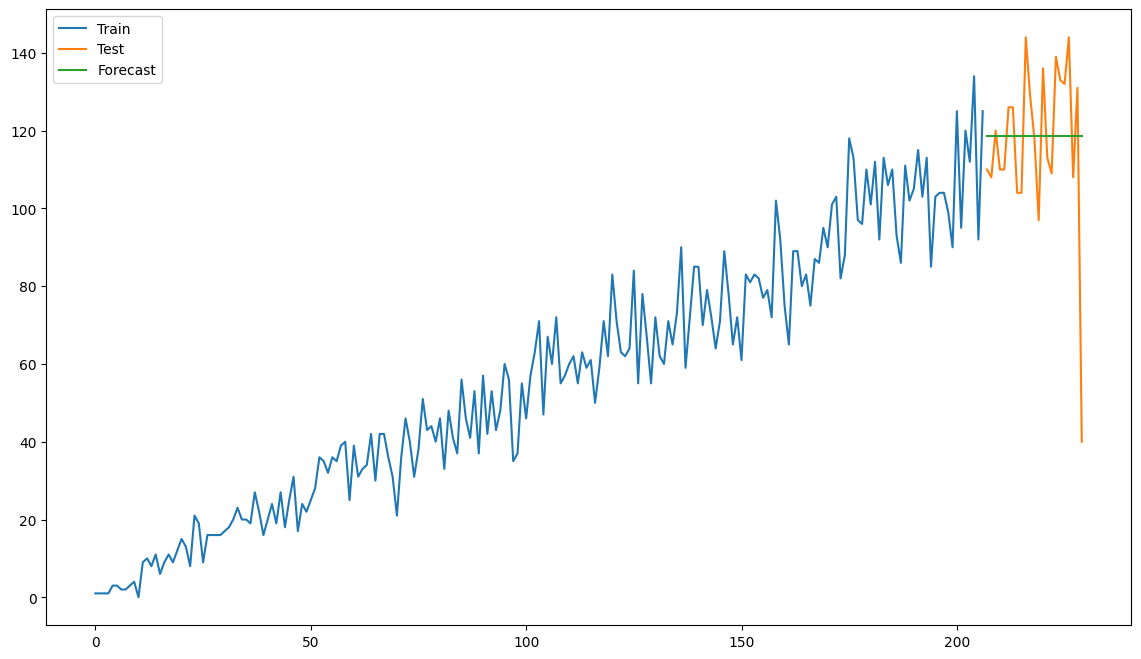

In [18]:
from numpy import mean
last_10_weeks = data['count'].tail(10)
last_10_weeks_mean = mean(last_10_weeks)
prediction = [last_10_weeks_mean for i in range(len(test))]
plt.figure(figsize=(14, 8))
plt.plot(train, label='Train')
plt.plot([None for i in train] + [x for x in test], label='Test')
plt.plot([None for i in train] + [x for x in prediction], label='Forecast')
plt.legend(loc='best')
plt.show()

In [20]:
rmse = sqrt(mean_squared_error(test, prediction))
print(f"RMSE: {rmse}")

RMSE: 21.268214699916378
